#Student Name: Yuan-Yao Lou
#ECE 595 Machine Learning II
#Project 3: GAN - Student Code

---

\\

In [ ]:
# Import necessary packages
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Part 1: Implementing the GAN

In [ ]:
# (1) Load MNIST data and normalize to [-1, 1] (originally [0, 255])
(data_train, _), (data_test, _) = mnist.load_data()
data_train = (data_train - 127.5) / 127.5
data_test  = (data_test  - 127.5) / 127.5

# (2) Reshape
data_train = np.reshape(data_train, (data_train.shape[0], -1))
data_test  = np.reshape(data_test,  (data_test.shape[0],  -1))

# Check
print('Train Data Shape: {0}; MAX: {1}; MIN: {2}'.format(data_train.shape,
                                                         np.amax(data_train),
                                                         np.amin(data_train)))
print('Test  Data Shape: {0}; MAX: {1}; MIN: {2}'.format(data_test.shape,
                                                         np.amax(data_test), 
                                                         np.amin(data_test)))

11501568/11490434 [==============================] - 2s 0us/step
Train Data Shape: (60000, 784); MAX: 1.0; MIN: -1.0
Test  Data Shape: (10000, 784); MAX: 1.0; MIN: -1.0


## Part 1.1: 10 sets each containing 25 sample images that were generated



Epoch 10000
10000: [Discriminaotr loss: 0.703024, acc: 0.265625]  [GAN loss: 0.771256, acc: 0.281250]


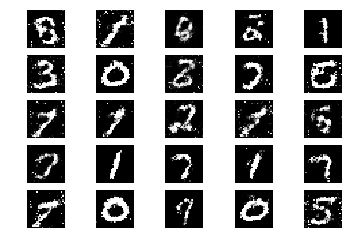

Epoch 20000
20000: [Discriminaotr loss: 0.672334, acc: 0.367188]  [GAN loss: 0.920166, acc: 0.250000]


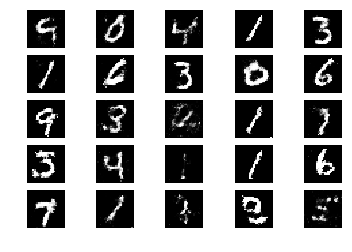

Epoch 30000
30000: [Discriminaotr loss: 0.676240, acc: 0.328125]  [GAN loss: 0.812076, acc: 0.281250]


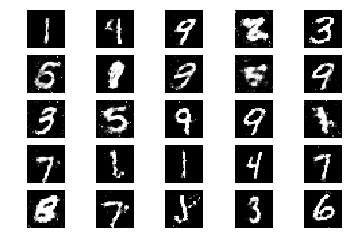

Epoch 40000
40000: [Discriminaotr loss: 0.659127, acc: 0.328125]  [GAN loss: 1.024209, acc: 0.171875]


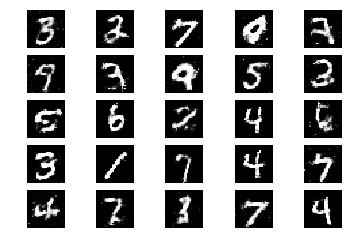

Epoch 50000
50000: [Discriminaotr loss: 0.630164, acc: 0.281250]  [GAN loss: 0.797918, acc: 0.390625]


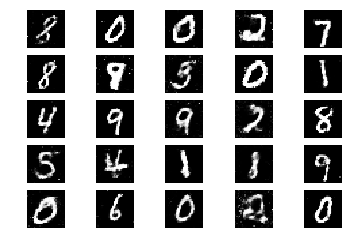

In [ ]:
# ===================================================================
#   Part 1.1 - 1.3: Default Setting                                 =
# ===================================================================

latent_dim = 100    # The D-dimensional noise vector length
data_dim   = 784    # Dimension of generated output


# ==========================================================================================


# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_discriminator():
    return adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

# Function that returns Adam optimizer for GAN model
def adam_GAN():
    return adam(learning_rate=0.001,  beta_1=0.5, beta_2=0.999)


# Genrerator model
def create_generator(input_dimension, output_dimension):
    generator = Sequential()

    generator.add(Dense(250, input_dim=input_dimension))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(500))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1000))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(output_dimension, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return generator

# Discriminator model
def create_discriminator(input_dimension):
    discriminator = Sequential()

    discriminator.add(Dense(1000, input_dim=input_dimension))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.4))

    discriminator.add(Dense(500))
    discriminator.add(LeakyReLU(0.2)) 
    discriminator.add(Dropout(0.4))

    discriminator.add(Dense(250))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_discriminator(), metrics=['accuracy'])
    return discriminator

# Create Generative Adversarial Networks (GAN)
def create_gan(input_dimension, discriminator, generator):
    discriminator.trainable = False

    GAN_input        = Input(shape=(input_dimension, ))
    generator_output = generator(GAN_input)
    GAN_output       = discriminator(generator_output)
    
    gan = Model(inputs=GAN_input, outputs=GAN_output)

    gan.compile(loss='binary_crossentropy', optimizer=adam_GAN(), metrics=['accuracy'])
    return gan


# ==========================================================================================


# Creating GAN
generator_1     = create_generator(latent_dim, data_dim)
discriminator_1 = create_discriminator(data_dim)
gan_1           = create_gan(latent_dim, discriminator_1, generator_1)

# Model and training parameters
epochs          = 50000
batch_size      = 64
sample_interval = 10000

# Array to save training history
training_meta_data_1 = np.zeros([epochs, 4])
d_loss_1   = np.zeros([2,])
gan_loss_1 = np.zeros([2,])

# Training the GAN
#   - Reference: 
#     (1) https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
#     (2) https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/
#     (3) https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator_1.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(0, data_train.shape[0], batch_size)]

    # Concatenate real and fake images into a single array (or batch) ***
    data_total = np.concatenate((fake_images, real_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real  = np.ones( (batch_size, 1))
    labels_fake  = np.zeros((batch_size, 1))
    labels_noise = labels_real - np.random.rand(batch_size, 1) / 100
    labels_discriminator = np.concatenate((labels_fake, labels_noise))

    # Allow discriminator parameters to be updated
    discriminator_1.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss_1[0], d_loss_1[1] = discriminator_1.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Keep discriminator weights constant while training generator
    discriminator_1.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images
    # Assign loss and accuracy to variable
    gan_loss_1[0], gan_loss_1[1] = gan_1.train_on_batch(noise, labels_real)


    # ==========================================================================================


    # Save training status
    # Discriminator and model loss
    training_meta_data_1[e-1, 0] = d_loss_1[0]
    training_meta_data_1[e-1, 1] = gan_loss_1[0]

    # Discriminator and model accuracy
    training_meta_data_1[e-1, 2] = d_loss_1[1]
    training_meta_data_1[e-1, 3] = gan_loss_1[1]

    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss_1[0], d_loss_1[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss_1[0], gan_loss_1[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator_1.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

## Part 1.2: Plot of Discriminator and GAN model loss vs. epoch




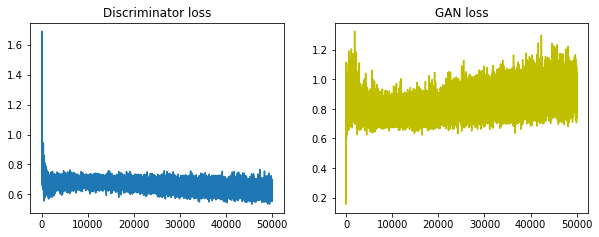

In [ ]:
# Plot model loss vs epoch
plt.figure(figsize = (10,3.5))
plt.subplot(121)
plt.title("Discriminator loss")
plt.plot(training_meta_data_1[:,0])
plt.subplot(122)
plt.title("GAN loss")
plt.plot(training_meta_data_1[:,1], 'y')

## Part 1.3: Plot of Discriminator and GAN model accuracy vs epoch
 



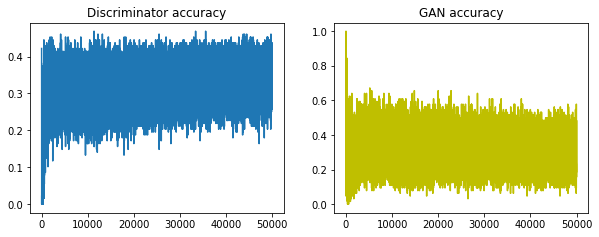

In [ ]:
# Plot accuracy vs epoch
plt.figure(figsize = (10,3.5))
plt.subplot(121)
plt.title("Discriminator accuracy")
plt.plot(training_meta_data_1[:,2])
plt.subplot(122)
plt.title("GAN accuracy")
plt.plot(training_meta_data_1[:,3], 'y')

## Part 1.4: Assess importance of dropout in the discriminator by removing Dropout layer



Epoch 10000
10000: [Discriminaotr loss: 0.678407, acc: 0.375000]  [GAN loss: 0.720711, acc: 0.609375]


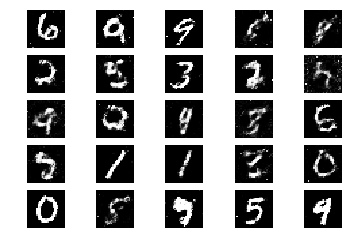

Epoch 20000
20000: [Discriminaotr loss: 0.597246, acc: 0.421875]  [GAN loss: 0.943999, acc: 0.312500]


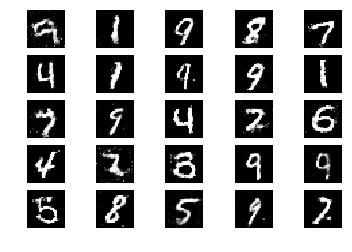

Epoch 30000
30000: [Discriminaotr loss: 0.534516, acc: 0.406250]  [GAN loss: 1.136281, acc: 0.234375]


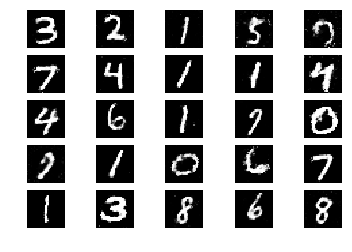

Epoch 40000
40000: [Discriminaotr loss: 0.496995, acc: 0.476562]  [GAN loss: 1.166256, acc: 0.296875]


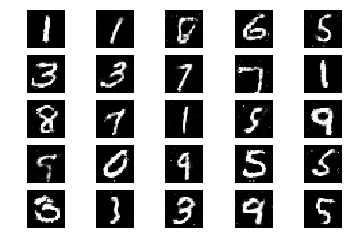

Epoch 50000
50000: [Discriminaotr loss: 0.489953, acc: 0.460938]  [GAN loss: 1.143679, acc: 0.312500]


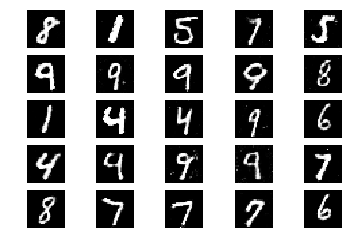

In [ ]:
# ===================================================================
#   Part 1.4: Without Dropout (Same hyper-parameters)               =
# ===================================================================

latent_dim = 100    # The D-dimensional noise vector length
data_dim   = 784    # Dimension of generated output


# ==========================================================================================


# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_discriminator():
    return adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

# Function that returns Adam optimizer for GAN model
def adam_GAN():
    return adam(learning_rate=0.001,  beta_1=0.5, beta_2=0.999)


# Genrerator model
def create_generator(input_dimension, output_dimension):
    generator = Sequential()

    generator.add(Dense(250, input_dim=input_dimension))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(500))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1000))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(output_dimension, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return generator

# Discriminator model
def create_discriminator(input_dimension):
    discriminator = Sequential()

    discriminator.add(Dense(1000, input_dim=input_dimension))
    discriminator.add(LeakyReLU(0.2))
    # discriminator.add(Dropout(0.4))

    discriminator.add(Dense(500))
    discriminator.add(LeakyReLU(0.2)) 
    # discriminator.add(Dropout(0.4))

    discriminator.add(Dense(250))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_discriminator(), metrics=['accuracy'])
    return discriminator

# Create Generative Adversarial Networks (GAN)
def create_gan(input_dimension, discriminator, generator):
    discriminator.trainable = False

    GAN_input        = Input(shape=(input_dimension, ))
    generator_output = generator(GAN_input)
    GAN_output       = discriminator(generator_output)
    
    gan = Model(inputs=GAN_input, outputs=GAN_output)

    gan.compile(loss='binary_crossentropy', optimizer=adam_GAN(), metrics=['accuracy'])
    return gan


# ==========================================================================================


# Creating GAN
generator     = create_generator(latent_dim, data_dim)
discriminator = create_discriminator(data_dim)
gan           = create_gan(latent_dim, discriminator, generator)

# Model and training parameters
epochs          = 50000
batch_size      = 64
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])
d_loss   = np.zeros([2,])
gan_loss = np.zeros([2,])

# Training the GAN
#   - Reference: https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(0, data_train.shape[0], batch_size)]

    # Concatenate real and fake images into a single array (or batch) ***
    data_total = np.concatenate((fake_images, real_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real  = np.ones( (batch_size, 1))
    labels_fake  = np.zeros((batch_size, 1))
    labels_noise = labels_real - np.random.rand(batch_size, 1) / 100
    labels_discriminator = np.concatenate((labels_fake, labels_noise))

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss[0], d_loss[1] = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images
    # Assign loss and accuracy to variable
    gan_loss[0], gan_loss[1] = gan.train_on_batch(noise, labels_real)


    # ==========================================================================================


    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]

    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

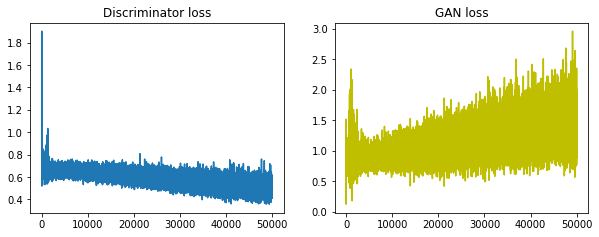

In [ ]:
# Plot model loss vs epoch
plt.figure(figsize = (10,3.5))
plt.subplot(121)
plt.title("Discriminator loss")
plt.plot(training_meta_data[:,0])
plt.subplot(122)
plt.title("GAN loss")
plt.plot(training_meta_data[:,1], 'y')

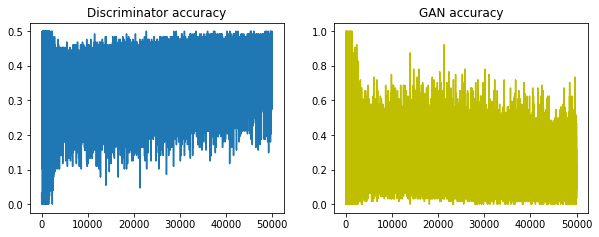

In [ ]:
# Plot accuracy vs epoch
plt.figure(figsize = (10,3.5))
plt.subplot(121)
plt.title("Discriminator accuracy")
plt.plot(training_meta_data[:,2])
plt.subplot(122)
plt.title("GAN accuracy")
plt.plot(training_meta_data[:,3], 'y')

## Part 1.5a: Increase dropout rate by 0.1 with the same hyper-parameter settings



Epoch 10000
10000: [Discriminaotr loss: 0.665799, acc: 0.257812]  [GAN loss: 0.722887, acc: 0.406250]


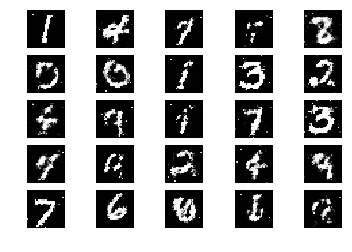

Epoch 20000
20000: [Discriminaotr loss: 0.674234, acc: 0.257812]  [GAN loss: 0.800160, acc: 0.250000]


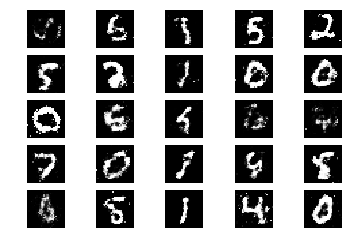

Epoch 30000
30000: [Discriminaotr loss: 0.645839, acc: 0.375000]  [GAN loss: 0.752757, acc: 0.406250]


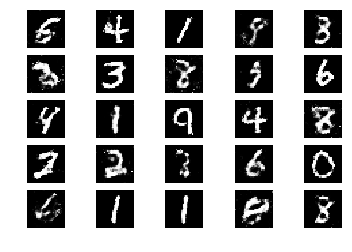

Epoch 40000
40000: [Discriminaotr loss: 0.664013, acc: 0.367188]  [GAN loss: 0.933602, acc: 0.281250]


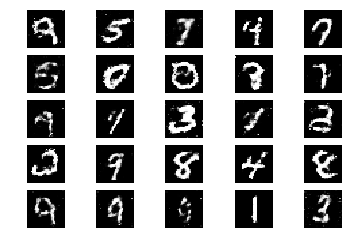

Epoch 50000
50000: [Discriminaotr loss: 0.659075, acc: 0.335938]  [GAN loss: 0.921254, acc: 0.250000]


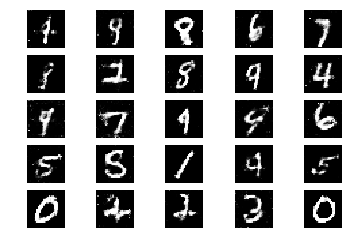

In [ ]:
# ===================================================================
#   Part 1.5: Increase Dropout Rate by 0.1 (Same hyper-parameters)  =
# ===================================================================

latent_dim = 100    # The D-dimensional noise vector length
data_dim   = 784    # Dimension of generated output


# ==========================================================================================


# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_discriminator():
    return adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

# Function that returns Adam optimizer for GAN model
def adam_GAN():
    return adam(learning_rate=0.001,  beta_1=0.5, beta_2=0.999)


# Genrerator model
def create_generator(input_dimension, output_dimension):
    generator = Sequential()

    generator.add(Dense(250, input_dim=input_dimension))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(500))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1000))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(output_dimension, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return generator

# Discriminator model
def create_discriminator(input_dimension):
    discriminator = Sequential()

    discriminator.add(Dense(1000, input_dim=input_dimension))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.5))

    discriminator.add(Dense(500))
    discriminator.add(LeakyReLU(0.2)) 
    discriminator.add(Dropout(0.5))

    discriminator.add(Dense(250))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_discriminator(), metrics=['accuracy'])
    return discriminator

# Create Generative Adversarial Networks (GAN)
def create_gan(input_dimension, discriminator, generator):
    discriminator.trainable = False

    GAN_input        = Input(shape=(input_dimension, ))
    generator_output = generator(GAN_input)
    GAN_output       = discriminator(generator_output)
    
    gan = Model(inputs=GAN_input, outputs=GAN_output)

    gan.compile(loss='binary_crossentropy', optimizer=adam_GAN(), metrics=['accuracy'])
    return gan


# ==========================================================================================


# Creating GAN
generator     = create_generator(latent_dim, data_dim)
discriminator = create_discriminator(data_dim)
gan           = create_gan(latent_dim, discriminator, generator)

# Model and training parameters
epochs          = 50000
batch_size      = 64
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])
d_loss   = np.zeros([2,])
gan_loss = np.zeros([2,])

# Training the GAN
#   - Reference: https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(0, data_train.shape[0], batch_size)]

    # Concatenate real and fake images into a single array (or batch) ***
    data_total = np.concatenate((fake_images, real_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real  = np.ones( (batch_size, 1))
    labels_fake  = np.zeros((batch_size, 1))
    labels_noise = labels_real - np.random.rand(batch_size, 1) / 100
    labels_discriminator = np.concatenate((labels_fake, labels_noise))

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss[0], d_loss[1] = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images
    # Assign loss and accuracy to variable
    gan_loss[0], gan_loss[1] = gan.train_on_batch(noise, labels_real)


    # ==========================================================================================


    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]

    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

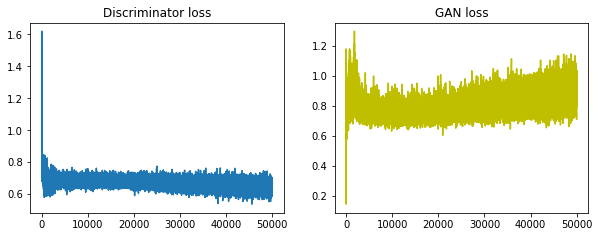

In [ ]:
# Plot model loss vs epoch
plt.figure(figsize = (10,3.5))
plt.subplot(121)
plt.title("Discriminator loss")
plt.plot(training_meta_data[:,0])
plt.subplot(122)
plt.title("GAN loss")
plt.plot(training_meta_data[:,1], 'y')

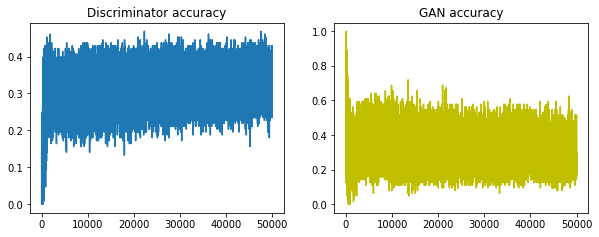

In [ ]:
# Plot accuracy vs epoch
plt.figure(figsize = (10,3.5))
plt.subplot(121)
plt.title("Discriminator accuracy")
plt.plot(training_meta_data[:,2])
plt.subplot(122)
plt.title("GAN accuracy")
plt.plot(training_meta_data[:,3], 'y')

## Part 1.5b: [Bonus] New hyper-parameter settings



Epoch 10000
10000: [Discriminaotr loss: 0.671577, acc: 0.320312]  [GAN loss: 0.924299, acc: 0.218750]


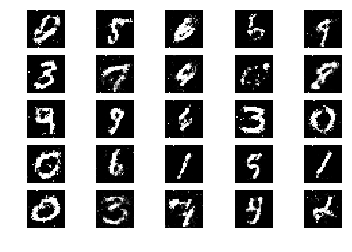

Epoch 20000
20000: [Discriminaotr loss: 0.650574, acc: 0.250000]  [GAN loss: 0.777797, acc: 0.390625]


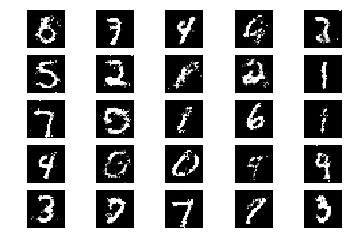

Epoch 30000
30000: [Discriminaotr loss: 0.656304, acc: 0.257812]  [GAN loss: 0.793548, acc: 0.343750]


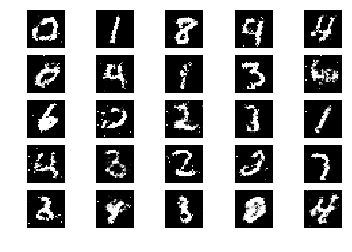

Epoch 40000
40000: [Discriminaotr loss: 0.655486, acc: 0.210938]  [GAN loss: 0.931528, acc: 0.171875]


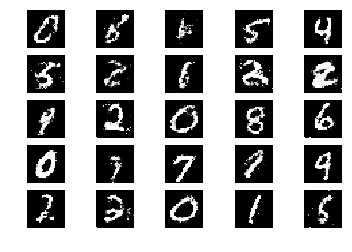

Epoch 50000
50000: [Discriminaotr loss: 0.706507, acc: 0.234375]  [GAN loss: 1.005218, acc: 0.078125]


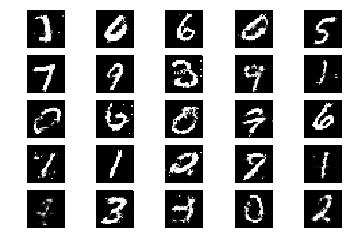

In [ ]:
# ===================================================================
#   Part 1.6: Bonus (New hyper-parameter settings)                  =
# ===================================================================

latent_dim = 100    # The D-dimensional noise vector length
data_dim   = 784    # Dimension of generated output


# ==========================================================================================


# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_discriminator():
    return adam(learning_rate=0.0008, beta_1=0.5, beta_2=0.999)

# Function that returns Adam optimizer for GAN model
def adam_GAN():
    return adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)


# Genrerator model
def create_generator(input_dimension, output_dimension):
    generator = Sequential()

    generator.add(Dense(250, input_dim=input_dimension))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(500))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1000))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(output_dimension, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return generator

# Discriminator model
def create_discriminator(input_dimension):
    discriminator = Sequential()

    discriminator.add(Dense(1000, input_dim=input_dimension))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.5))

    discriminator.add(Dense(500))
    discriminator.add(LeakyReLU(0.2)) 
    discriminator.add(Dropout(0.5))

    discriminator.add(Dense(250))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_discriminator(), metrics=['accuracy'])
    return discriminator

# Create Generative Adversarial Networks (GAN)
def create_gan(input_dimension, discriminator, generator):
    discriminator.trainable = False

    GAN_input        = Input(shape=(input_dimension, ))
    generator_output = generator(GAN_input)
    GAN_output       = discriminator(generator_output)
    
    gan = Model(inputs=GAN_input, outputs=GAN_output)

    gan.compile(loss='binary_crossentropy', optimizer=adam_GAN(), metrics=['accuracy'])
    return gan


# ==========================================================================================


# Creating GAN
generator     = create_generator(latent_dim, data_dim)
discriminator = create_discriminator(data_dim)
gan           = create_gan(latent_dim, discriminator, generator)

# Model and training parameters
epochs          = 50000
batch_size      = 64
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])
d_loss   = np.zeros([2,])
gan_loss = np.zeros([2,])

# Training the GAN
#   - Reference: https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(0, data_train.shape[0], batch_size)]

    # Concatenate real and fake images into a single array (or batch) ***
    data_total = np.concatenate((fake_images, real_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real  = np.ones( (batch_size, 1))
    labels_fake  = np.zeros((batch_size, 1))
    labels_noise = labels_real - np.random.rand(batch_size, 1) / 100
    labels_discriminator = np.concatenate((labels_fake, labels_noise))

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss[0], d_loss[1] = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images
    # Assign loss and accuracy to variable
    gan_loss[0], gan_loss[1] = gan.train_on_batch(noise, labels_real)


    # ==========================================================================================


    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]

    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

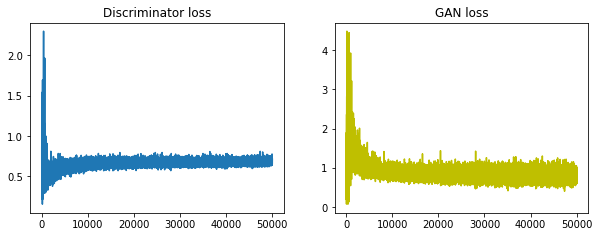

In [ ]:
# Plot model loss vs epoch
plt.figure(figsize = (10,3.5))
plt.subplot(121)
plt.title("Discriminator loss")
plt.plot(training_meta_data[:,0])
plt.subplot(122)
plt.title("GAN loss")
plt.plot(training_meta_data[:,1], 'y')

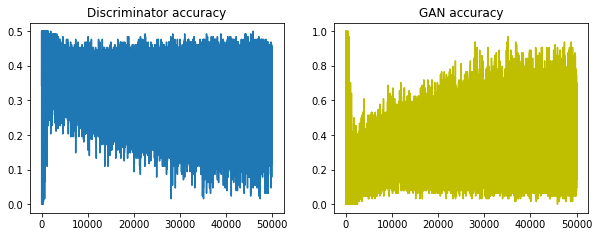

In [ ]:
# Plot accuracy vs epoch
plt.figure(figsize = (10,3.5))
plt.subplot(121)
plt.title("Discriminator accuracy")
plt.plot(training_meta_data[:,2])
plt.subplot(122)
plt.title("GAN accuracy")
plt.plot(training_meta_data[:,3], 'y')

[4]. Compare and comment on the results of GAN with dropout and without dropout.

  ANS: If there is no dropout layer in the discriminator model, overfitting might happen. It means that the generator fails to fool the discriminator. In contrast, we need dropout layers in the discriminator model to prevent overfitting and memorization, so that generator can fool the discriminator successfully.


[5][a]. Comment on importance of hyper-parameter tuning

  ANS: GAN is highly sensitive to each hyper-parameter (e.g., learning rate, dropout rate, and the noise for the training sample for the generator). It does take lots of trail-and-errors to figure out what kind of settings make sense and get the model to work expectedly. Generally, when tunning the hyper-parameter, the primary principle is not to make the discriminator too powerful so that the generator can indeed learn things along the training process.


[5][b]. Bonus: With the new dropout rate in every dropout layer, find other hyperparameter settings which produce similar or better results than 1.

  ANS: I increase the learning rate of the discriminator's optimizer to 0.008 and decrease the learning rate of the adversarial model's optimizer to 0.002. The motivation is to avoid discriminator loss converging rapidly to zero thus preventing the generator from learning. And the results are slightly better.


[6]. Answer the following questions:


1.   Why does the accuracy of the discriminator remain around 50%? Is this a good trait of the GAN? 

  ANS: As the generator improves with training, the discriminator performance gets worse because the discriminator can't easily tell the difference between real and fake. If the generator succeeds perfectly, then the discriminator has a 50% accuracy. In effect, the discriminator flips a coin to make its prediction.

  This is not a good trait of the GAN since this progression poses a problem for convergence of the GAN as a whole: the discriminator feedback gets less meaningful over time. If the GAN continues training past the point when the discriminator is giving completely random feedback, then the generator starts to train on junk feedback, and its own quality may collapse.


2.   How could this model be modified to produce cleaner (less noisy) images? 

  ANS: Instead of using fully connected (dense) layer in the generator, we could use convolutional layer.

# Part 2: Generating samples using trained generator

In [ ]:
# Generate ten images from Gaussian noise using the trained generator from Part 1
noise_test = np.random.normal(0, 1, (10, latent_dim))
generated_images = generator_1.predict(noise_test)

# Re-scale generated images to lie in [0, 1]
generated_images = 0.5 * generated_images + 0.5

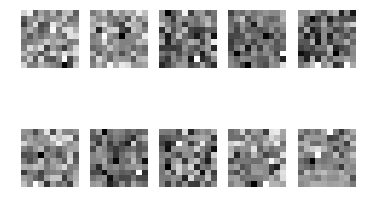

In [ ]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((noise[cnt].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

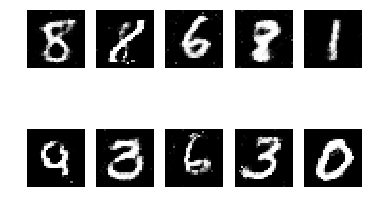

In [ ]:
# Visualize generated samples
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((generated_images[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

# Part 3: Testing accuracy of generated images on ten samples

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/MyDrive/Colab Notebooks'

# Load mnist classifier and generated images
mnist_classifier = load_model('/content/drive/MyDrive/Colab Notebooks/mnist_classifier.h5')

In [ ]:
# ASSIGN CLASSES
labels = [8, 8, 6, 8, 1, 9, 3, 6, 3, 0]

# Convert integer labels to one-hot labels 
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

# Show classifications
result = mnist_classifier.predict(generated_images)
print('Classification Sesult: {0}'.format(np.argmax(result, axis=1).tolist()))

# Evaluate accuracy
_, acc = mnist_classifier.evaluate(generated_images, labels)
print('Accuracy: {0}'.format(acc))

Classification Sesult: [8, 8, 6, 8, 1, 9, 3, 6, 3, 0]
10/10 [==============================] - 0s 229us/step
Accuracy: 1.0


[3]. Answer the following questions:

1.   State the accuracy of the classifier on your ten generated images. Based on this accuracy, would you say your generator does well in producing images comparable to those in the MNIST dataset of hand-written digits? Why or why not? 

  ANS: The accuracy is 1.0 (100%). The perfect accuracy indicates that my generator performs well in producing images comparable to the MNIST dataset of hand-written digits. The reason why is that the generated fake images share a similar pattern with the MNIST dataset, so the generator can fool the discriminator successfully.

2.   In this project, we only tested the performance of the pre-trained classifier on ten samples and used its result to determine the robustness of the generator. How could we better assess the quality of the generated images using this pre-trained classifier and the saved generator?

  ANS: With a larger size of samples, the variance of the statistical error caused by the generated images that may look like multiple classes comes up. Therefore, we could better assess the quality of the generated images using the pre-trained classifies and the saved generator.